SETUP

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
os.chdir('..')
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")   # Run only if necessary

from src.data.Dataset import Dataset as DS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Check if GPU is available

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

DATASET

In [4]:
# Dataset generator

n = 10
m = 5
hop = 1/1200
input_dim   = 30 * n
pred_dim    = 0.25
shift       = pred_dim
batch_size  = 256
Data        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll','heave','pitch','wave']
                )

In [5]:
Data.Train.element_spec

(TensorSpec(shape=(None, 1200, 4), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))

In [6]:
INPUT_DIM = Data.xshape
OUTPUT_DIM = Data.yshape

print('Input dim:', INPUT_DIM)
print('Output dim:', OUTPUT_DIM)

Input dim: [1200, 4]
Output dim: [1, 1]


MODEL

In [7]:
# Loss functions

# Regression loss
MSE_loss = tf.keras.losses.MeanSquaredError()
MAE_loss = tf.keras.losses.MeanAbsoluteError()

# Metrics

# Regression metrics
MAPE = tf.keras.metrics.MeanAbsolutePercentageError()
MAE = tf.keras.metrics.MeanAbsoluteError()

In [8]:
# norm = tf.keras.layers.Normalization(input_shape=INPUT_DIM, axis=-1)
# x_ds = Data.Train.map(lambda x, y: x)
# norm.adapt(x_ds)

In [9]:
# Define model here

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_DIM),
    tf.keras.layers.LSTM(units=256, return_sequences=True),
    tf.keras.layers.LSTM(units=64, return_sequences=False),
#     tf.keras.layers.LSTM(units=32, return_sequences=False),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(OUTPUT_DIM[0])
])

In [10]:
# Compile model

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=MSE_loss, metrics=[MAPE, MAE])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1200, 256)         267264    
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 351,553
Trainable params: 351,553
Non-trainable params: 0
_________________________________________________________________


In [15]:
from statsmodels.tsa.stattools import adfuller
import arch.unitroot as at
def check_stationary_adf(data):
    stat=adfuller(data)
    p_val=stat[1]
    print(p_val)
    if p_val<=0.05:
        return True
    else:
        return False
def check_stationary_pf(data):
    result=at.PhillipsPerron(data,trend='ct',test_type='tau')
    p_val=result.pvalue
    if p_val<=0.05:
        return True
    else:
        return False

In [18]:
time, heave, roll, pitch, wave = Data.get_sim_data(1)

In [33]:
# Check if model is working and the output shape
Data.batch_size = 1

for x, y in Data.Train.take(10):
    roll = x[0][:,0]
    heave = x[0][:,1]
    pitch = x[0][:,2]
    wave = x[0][:,3]
    
    print('Roll: ', check_stationary_adf(roll))
    print('Heave: ', check_stationary_adf(heave))
    print('Pitch: ', check_stationary_adf(pitch))
    print('Wave: ', check_stationary_adf(wave))

4.835287818370694e-08
Roll:  True
7.325744391173554e-12
Heave:  True
5.321882477354829e-19
Pitch:  True
0.0
Wave:  True
4.676529414648116e-08
Roll:  True
7.295698971052629e-12
Heave:  True
5.2140395330120015e-19
Pitch:  True
0.6653874341155762
Wave:  False
4.6151523875495834e-08
Roll:  True
7.342887072528818e-12
Heave:  True
4.765430457427522e-19
Pitch:  True
0.9281408379127254
Wave:  False
4.6032150034035444e-08
Roll:  True
7.372244685367294e-12
Heave:  True
4.500227977629233e-19
Pitch:  True
0.5294911041204904
Wave:  False
4.587020902602591e-08
Roll:  True
7.361492710330001e-12
Heave:  True
4.533119258925123e-19
Pitch:  True
0.9088658874156499
Wave:  False
5.314136667912193e-08
Roll:  True
7.356411974941345e-12
Heave:  True
4.377291644254324e-19
Pitch:  True
0.8882188093838121
Wave:  False
3.8379959754069785e-08
Roll:  True
7.2721506901907465e-12
Heave:  True
4.536965350987753e-19
Pitch:  True
0.8707407181936266
Wave:  False
4.8086150843609306e-08
Roll:  True
7.247365642455397e-12
He

In [19]:
print('Roll: ', check_stationary_adf(roll))
print('Heave: ', check_stationary_adf(heave))
print('Pitch: ', check_stationary_adf(pitch))
print('Wave: ', check_stationary_adf(wave))

0.0
Roll:  True
0.0
Heave:  True
0.0
Pitch:  True
0.0
Wave:  True


In [20]:
print('Roll: ', check_stationary_pf(roll))
print('Heave: ', check_stationary_pf(heave))
print('Pitch: ', check_stationary_pf(pitch))
print('Wave: ', check_stationary_pf(wave))

Roll:  True
Heave:  True
Pitch:  True
Wave:  True


TRAINING

In [11]:
# Defining the required callbacks
from datetime import datetime

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=7,
                                                    mode='min')

checkpoint_filepath = 'models/RNN/11/model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001)

logdir = "logs/11/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, update_freq=500)

In [12]:
logdir = 'models/RNN/08/metrics'

%tensorboard --logdir logs/11

In [13]:
# Model training

history = model.fit(Data.Val, epochs=100, validation_data=Data.Test, callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/100
    994/Unknown - 564s 561ms/step - loss: 3.4355e-05 - mean_absolute_percentage_error: 72.0926 - mean_absolute_error: 0.0022

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 962s 962ms/step - loss: 3.4355e-05 - mean_absolute_percentage_error: 72.0926 - mean_absolute_error: 0.0022 - val_loss: 1.8901e-06 - val_mean_absolute_percentage_error: 5.0155 - val_mean_absolute_error: 5.5246e-04
Epoch 2/100
994/994 [==============================] - ETA: 0s - loss: 1.3067e-05 - mean_absolute_percentage_error: 22.1290 - mean_absolute_error: 0.0011

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 969s 975ms/step - loss: 1.3067e-05 - mean_absolute_percentage_error: 22.1290 - mean_absolute_error: 0.0011 - val_loss: 7.0963e-07 - val_mean_absolute_percentage_error: 3.2915 - val_mean_absolute_error: 3.4893e-04
Epoch 3/100
994/994 [==============================] - ETA: 0s - loss: 5.5438e-06 - mean_absolute_percentage_error: 18.3111 - mean_absolute_error: 8.2785e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 967s 973ms/step - loss: 5.5438e-06 - mean_absolute_percentage_error: 18.3111 - mean_absolute_error: 8.2785e-04 - val_loss: 5.4919e-07 - val_mean_absolute_percentage_error: 3.6654 - val_mean_absolute_error: 3.1156e-04
Epoch 4/100
994/994 [==============================] - ETA: 0s - loss: 1.0129e-05 - mean_absolute_percentage_error: 23.0604 - mean_absolute_error: 9.5451e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 970s 976ms/step - loss: 1.0129e-05 - mean_absolute_percentage_error: 23.0604 - mean_absolute_error: 9.5451e-04 - val_loss: 3.5765e-07 - val_mean_absolute_percentage_error: 2.7093 - val_mean_absolute_error: 2.4677e-04
Epoch 5/100
994/994 [==============================] - ETA: 0s - loss: 1.1824e-06 - mean_absolute_percentage_error: 8.9113 - mean_absolute_error: 4.3188e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 968s 974ms/step - loss: 1.1824e-06 - mean_absolute_percentage_error: 8.9113 - mean_absolute_error: 4.3188e-04 - val_loss: 1.7400e-07 - val_mean_absolute_percentage_error: 2.7705 - val_mean_absolute_error: 1.8418e-04
Epoch 6/100
994/994 [==============================] - 965s 971ms/step - loss: 6.5464e-06 - mean_absolute_percentage_error: 20.9074 - mean_absolute_error: 7.9280e-04 - val_loss: 1.8670e-07 - val_mean_absolute_percentage_error: 2.6726 - val_mean_absolute_error: 1.8641e-04
Epoch 7/100
994/994 [==============================] - ETA: 0s - loss: 1.9441e-06 - mean_absolute_percentage_error: 11.6159 - mean_absolute_error: 4.8374e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 968s 974ms/step - loss: 1.9441e-06 - mean_absolute_percentage_error: 11.6159 - mean_absolute_error: 4.8374e-04 - val_loss: 1.1648e-07 - val_mean_absolute_percentage_error: 2.3002 - val_mean_absolute_error: 1.4767e-04
Epoch 8/100
994/994 [==============================] - ETA: 0s - loss: 6.8590e-06 - mean_absolute_percentage_error: 10.1211 - mean_absolute_error: 7.7878e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 969s 974ms/step - loss: 6.8590e-06 - mean_absolute_percentage_error: 10.1211 - mean_absolute_error: 7.7878e-04 - val_loss: 8.2779e-08 - val_mean_absolute_percentage_error: 1.5059 - val_mean_absolute_error: 1.2553e-04
Epoch 9/100
994/994 [==============================] - ETA: 0s - loss: 4.8958e-06 - mean_absolute_percentage_error: 11.5647 - mean_absolute_error: 5.7672e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 969s 975ms/step - loss: 4.8958e-06 - mean_absolute_percentage_error: 11.5647 - mean_absolute_error: 5.7672e-04 - val_loss: 5.9603e-08 - val_mean_absolute_percentage_error: 1.2414 - val_mean_absolute_error: 1.0860e-04
Epoch 10/100
994/994 [==============================] - ETA: 0s - loss: 3.2878e-07 - mean_absolute_percentage_error: 4.2189 - mean_absolute_error: 2.3767e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 968s 974ms/step - loss: 3.2878e-07 - mean_absolute_percentage_error: 4.2189 - mean_absolute_error: 2.3767e-04 - val_loss: 4.7131e-08 - val_mean_absolute_percentage_error: 1.0898 - val_mean_absolute_error: 9.3842e-05
Epoch 11/100
994/994 [==============================] - 965s 971ms/step - loss: 6.2705e-06 - mean_absolute_percentage_error: 12.2997 - mean_absolute_error: 6.6538e-04 - val_loss: 5.1120e-08 - val_mean_absolute_percentage_error: 1.1076 - val_mean_absolute_error: 9.8410e-05
Epoch 12/100
994/994 [==============================] - ETA: 0s - loss: 5.6956e-06 - mean_absolute_percentage_error: 8.5431 - mean_absolute_error: 5.7538e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 966s 972ms/step - loss: 5.6956e-06 - mean_absolute_percentage_error: 8.5431 - mean_absolute_error: 5.7538e-04 - val_loss: 4.1092e-08 - val_mean_absolute_percentage_error: 0.9868 - val_mean_absolute_error: 8.7581e-05
Epoch 13/100
994/994 [==============================] - ETA: 0s - loss: 6.5324e-07 - mean_absolute_percentage_error: 14.0669 - mean_absolute_error: 3.1810e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 968s 974ms/step - loss: 6.5324e-07 - mean_absolute_percentage_error: 14.0669 - mean_absolute_error: 3.1810e-04 - val_loss: 2.5690e-08 - val_mean_absolute_percentage_error: 0.8946 - val_mean_absolute_error: 7.0342e-05
Epoch 14/100
994/994 [==============================] - 961s 967ms/step - loss: 8.4914e-06 - mean_absolute_percentage_error: 9.5404 - mean_absolute_error: 6.9047e-04 - val_loss: 5.6812e-08 - val_mean_absolute_percentage_error: 0.9794 - val_mean_absolute_error: 1.0119e-04
Epoch 15/100
994/994 [==============================] - 960s 967ms/step - loss: 1.3027e-06 - mean_absolute_percentage_error: 14.5496 - mean_absolute_error: 3.8408e-04 - val_loss: 4.4226e-08 - val_mean_absolute_percentage_error: 0.8753 - val_mean_absolute_error: 8.3948e-05
Epoch 16/100
994/994 [==============================] - ETA: 0s - loss: 5.2040e-07 - mean_absolute_percentage_error: 6.1832 - mean_absolute_error: 2.4624e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 964s 970ms/step - loss: 5.2040e-07 - mean_absolute_percentage_error: 6.1832 - mean_absolute_error: 2.4624e-04 - val_loss: 1.8449e-08 - val_mean_absolute_percentage_error: 0.8083 - val_mean_absolute_error: 5.9117e-05
Epoch 17/100
994/994 [==============================] - 964s 970ms/step - loss: 1.0037e-05 - mean_absolute_percentage_error: 29.9841 - mean_absolute_error: 9.7495e-04 - val_loss: 9.4470e-08 - val_mean_absolute_percentage_error: 1.2234 - val_mean_absolute_error: 1.2268e-04
Epoch 18/100
994/994 [==============================] - 963s 969ms/step - loss: 1.8045e-07 - mean_absolute_percentage_error: 2.7596 - mean_absolute_error: 1.8555e-04 - val_loss: 2.8664e-08 - val_mean_absolute_percentage_error: 1.1895 - val_mean_absolute_error: 7.5585e-05
Epoch 19/100
994/994 [==============================] - 963s 969ms/step - loss: 3.9927e-06 - mean_absolute_percentage_error: 6.2387 - mean_absolute_error: 4.6333e-04 - val_loss: 2.6971e-08 - val_m

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 967s 973ms/step - loss: 1.0005e-06 - mean_absolute_percentage_error: 4.5127 - mean_absolute_error: 3.1558e-04 - val_loss: 1.6492e-08 - val_mean_absolute_percentage_error: 0.7035 - val_mean_absolute_error: 5.2578e-05
Epoch 27/100
994/994 [==============================] - 958s 964ms/step - loss: 4.8414e-06 - mean_absolute_percentage_error: 7.1481 - mean_absolute_error: 5.4278e-04 - val_loss: 3.4575e-08 - val_mean_absolute_percentage_error: 0.8160 - val_mean_absolute_error: 7.1831e-05
Epoch 28/100
994/994 [==============================] - 962s 968ms/step - loss: 9.2929e-06 - mean_absolute_percentage_error: 20.9705 - mean_absolute_error: 7.9186e-04 - val_loss: 3.5844e-08 - val_mean_absolute_percentage_error: 0.7321 - val_mean_absolute_error: 6.4615e-05
Epoch 29/100
994/994 [==============================] - 960s 966ms/step - loss: 1.7068e-07 - mean_absolute_percentage_error: 12.5721 - mean_absolute_error: 1.9800e-04 - val_loss: 2.7730e-08 - val_

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 953s 959ms/step - loss: 3.1180e-07 - mean_absolute_percentage_error: 11.8097 - mean_absolute_error: 2.3831e-04 - val_loss: 1.5580e-08 - val_mean_absolute_percentage_error: 0.7434 - val_mean_absolute_error: 4.5471e-05
Epoch 43/100
994/994 [==============================] - 945s 951ms/step - loss: 6.6220e-06 - mean_absolute_percentage_error: 25.4624 - mean_absolute_error: 7.6174e-04 - val_loss: 3.0698e-08 - val_mean_absolute_percentage_error: 0.8076 - val_mean_absolute_error: 5.4585e-05
Epoch 44/100
994/994 [==============================] - 947s 953ms/step - loss: 2.0050e-07 - mean_absolute_percentage_error: 8.4241 - mean_absolute_error: 1.8874e-04 - val_loss: 2.0473e-08 - val_mean_absolute_percentage_error: 0.5870 - val_mean_absolute_error: 4.6655e-05
Epoch 45/100
994/994 [==============================] - ETA: 0s - loss: 1.5488e-06 - mean_absolute_percentage_error: 16.7845 - mean_absolute_error: 3.9343e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 951s 957ms/step - loss: 1.5488e-06 - mean_absolute_percentage_error: 16.7845 - mean_absolute_error: 3.9343e-04 - val_loss: 1.4674e-08 - val_mean_absolute_percentage_error: 0.5805 - val_mean_absolute_error: 4.2721e-05
Epoch 46/100
994/994 [==============================] - 940s 946ms/step - loss: 1.9133e-07 - mean_absolute_percentage_error: 11.1246 - mean_absolute_error: 2.0716e-04 - val_loss: 1.4989e-06 - val_mean_absolute_percentage_error: 79.2561 - val_mean_absolute_error: 0.0012
Epoch 47/100
994/994 [==============================] - 947s 953ms/step - loss: 8.5785e-06 - mean_absolute_percentage_error: 16.0924 - mean_absolute_error: 7.0061e-04 - val_loss: 4.0022e-08 - val_mean_absolute_percentage_error: 1.1414 - val_mean_absolute_error: 6.4494e-05
Epoch 48/100
994/994 [==============================] - 944s 950ms/step - loss: 5.1732e-06 - mean_absolute_percentage_error: 56.6832 - mean_absolute_error: 8.5628e-04 - val_loss: 2.2787e-08 - val_m

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 952s 958ms/step - loss: 8.8587e-07 - mean_absolute_percentage_error: 9.0670 - mean_absolute_error: 3.6835e-04 - val_loss: 1.1723e-08 - val_mean_absolute_percentage_error: 0.6307 - val_mean_absolute_error: 3.8873e-05
Epoch 54/100
994/994 [==============================] - 942s 947ms/step - loss: 5.0768e-06 - mean_absolute_percentage_error: 46.3792 - mean_absolute_error: 8.0600e-04 - val_loss: 1.9983e-08 - val_mean_absolute_percentage_error: 1.4406 - val_mean_absolute_error: 6.6521e-05
Epoch 55/100
994/994 [==============================] - ETA: 0s - loss: 4.5576e-08 - mean_absolute_percentage_error: 2.8233 - mean_absolute_error: 8.6849e-05

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 946s 952ms/step - loss: 4.5576e-08 - mean_absolute_percentage_error: 2.8233 - mean_absolute_error: 8.6849e-05 - val_loss: 9.4928e-09 - val_mean_absolute_percentage_error: 0.8690 - val_mean_absolute_error: 3.9605e-05
Epoch 56/100
994/994 [==============================] - 945s 951ms/step - loss: 4.8604e-07 - mean_absolute_percentage_error: 9.9439 - mean_absolute_error: 2.4830e-04 - val_loss: 1.0242e-08 - val_mean_absolute_percentage_error: 0.6480 - val_mean_absolute_error: 3.7615e-05
Epoch 57/100
994/994 [==============================] - ETA: 0s - loss: 1.4582e-06 - mean_absolute_percentage_error: 5.7310 - mean_absolute_error: 3.1539e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 950s 956ms/step - loss: 1.4582e-06 - mean_absolute_percentage_error: 5.7310 - mean_absolute_error: 3.1539e-04 - val_loss: 9.0923e-09 - val_mean_absolute_percentage_error: 0.8737 - val_mean_absolute_error: 4.0508e-05
Epoch 58/100
994/994 [==============================] - 947s 952ms/step - loss: 2.0205e-07 - mean_absolute_percentage_error: 7.1143 - mean_absolute_error: 1.7443e-04 - val_loss: 9.6857e-09 - val_mean_absolute_percentage_error: 1.4568 - val_mean_absolute_error: 4.6497e-05
Epoch 59/100
994/994 [==============================] - ETA: 0s - loss: 4.2162e-06 - mean_absolute_percentage_error: 10.2174 - mean_absolute_error: 5.0258e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 950s 956ms/step - loss: 4.2162e-06 - mean_absolute_percentage_error: 10.2174 - mean_absolute_error: 5.0258e-04 - val_loss: 6.5571e-09 - val_mean_absolute_percentage_error: 0.6771 - val_mean_absolute_error: 3.4880e-05
Epoch 60/100
994/994 [==============================] - 946s 952ms/step - loss: 4.9183e-07 - mean_absolute_percentage_error: 4.6239 - mean_absolute_error: 1.9150e-04 - val_loss: 7.0419e-09 - val_mean_absolute_percentage_error: 0.6905 - val_mean_absolute_error: 3.5066e-05
Epoch 61/100
994/994 [==============================] - 948s 954ms/step - loss: 1.3600e-07 - mean_absolute_percentage_error: 8.8329 - mean_absolute_error: 1.7471e-04 - val_loss: 2.3815e-07 - val_mean_absolute_percentage_error: 19.7697 - val_mean_absolute_error: 3.9484e-04
Epoch 62/100
994/994 [==============================] - 948s 954ms/step - loss: 7.1153e-06 - mean_absolute_percentage_error: 31.5862 - mean_absolute_error: 7.7771e-04 - val_loss: 9.7673e-09 - val

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 945s 951ms/step - loss: 2.3357e-08 - mean_absolute_percentage_error: 1.6970 - mean_absolute_error: 6.4290e-05 - val_loss: 6.1728e-09 - val_mean_absolute_percentage_error: 0.6967 - val_mean_absolute_error: 3.4381e-05
Epoch 69/100
994/994 [==============================] - 942s 948ms/step - loss: 5.2889e-08 - mean_absolute_percentage_error: 3.8884 - mean_absolute_error: 1.0977e-04 - val_loss: 3.3254e-08 - val_mean_absolute_percentage_error: 3.6345 - val_mean_absolute_error: 1.0815e-04
Epoch 70/100
994/994 [==============================] - ETA: 0s - loss: 6.9900e-07 - mean_absolute_percentage_error: 4.4978 - mean_absolute_error: 2.6531e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 944s 950ms/step - loss: 6.9900e-07 - mean_absolute_percentage_error: 4.4978 - mean_absolute_error: 2.6531e-04 - val_loss: 6.1136e-09 - val_mean_absolute_percentage_error: 0.6304 - val_mean_absolute_error: 3.2208e-05
Epoch 71/100
994/994 [==============================] - 946s 952ms/step - loss: 9.1177e-07 - mean_absolute_percentage_error: 6.0676 - mean_absolute_error: 2.6552e-04 - val_loss: 7.3230e-09 - val_mean_absolute_percentage_error: 0.8179 - val_mean_absolute_error: 3.5353e-05
Epoch 72/100
994/994 [==============================] - 942s 948ms/step - loss: 3.5382e-07 - mean_absolute_percentage_error: 7.9523 - mean_absolute_error: 1.9914e-04 - val_loss: 6.3790e-09 - val_mean_absolute_percentage_error: 0.7167 - val_mean_absolute_error: 3.2029e-05
Epoch 73/100
994/994 [==============================] - ETA: 0s - loss: 1.4384e-06 - mean_absolute_percentage_error: 4.1878 - mean_absolute_error: 3.1682e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 946s 952ms/step - loss: 1.4384e-06 - mean_absolute_percentage_error: 4.1878 - mean_absolute_error: 3.1682e-04 - val_loss: 4.7727e-09 - val_mean_absolute_percentage_error: 0.5944 - val_mean_absolute_error: 3.0529e-05
Epoch 74/100
994/994 [==============================] - 942s 948ms/step - loss: 1.3501e-07 - mean_absolute_percentage_error: 5.2782 - mean_absolute_error: 1.3981e-04 - val_loss: 5.3194e-09 - val_mean_absolute_percentage_error: 0.7133 - val_mean_absolute_error: 3.1536e-05
Epoch 75/100
994/994 [==============================] - ETA: 0s - loss: 1.3798e-06 - mean_absolute_percentage_error: 6.8070 - mean_absolute_error: 3.2295e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 948s 954ms/step - loss: 1.3798e-06 - mean_absolute_percentage_error: 6.8070 - mean_absolute_error: 3.2295e-04 - val_loss: 4.7628e-09 - val_mean_absolute_percentage_error: 0.6480 - val_mean_absolute_error: 3.0858e-05
Epoch 76/100
994/994 [==============================] - 946s 952ms/step - loss: 1.1760e-07 - mean_absolute_percentage_error: 7.5125 - mean_absolute_error: 1.4689e-04 - val_loss: 4.8131e-08 - val_mean_absolute_percentage_error: 7.9349 - val_mean_absolute_error: 1.6690e-04
Epoch 77/100
994/994 [==============================] - 942s 948ms/step - loss: 1.9799e-06 - mean_absolute_percentage_error: 4.8939 - mean_absolute_error: 3.2543e-04 - val_loss: 4.8872e-09 - val_mean_absolute_percentage_error: 0.8305 - val_mean_absolute_error: 3.4001e-05
Epoch 78/100
994/994 [==============================] - 942s 948ms/step - loss: 6.4826e-08 - mean_absolute_percentage_error: 7.0444 - mean_absolute_error: 1.4770e-04 - val_loss: 2.9389e-08 - val_me

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 948s 954ms/step - loss: 1.5808e-06 - mean_absolute_percentage_error: 9.4880 - mean_absolute_error: 3.4127e-04 - val_loss: 4.5853e-09 - val_mean_absolute_percentage_error: 0.8494 - val_mean_absolute_error: 3.2315e-05
Epoch 82/100
994/994 [==============================] - 943s 949ms/step - loss: 6.7646e-08 - mean_absolute_percentage_error: 7.2550 - mean_absolute_error: 1.4052e-04 - val_loss: 5.9116e-08 - val_mean_absolute_percentage_error: 2.9237 - val_mean_absolute_error: 1.3184e-04
Epoch 83/100
994/994 [==============================] - ETA: 0s - loss: 1.1219e-06 - mean_absolute_percentage_error: 4.5029 - mean_absolute_error: 2.7100e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 948s 954ms/step - loss: 1.1219e-06 - mean_absolute_percentage_error: 4.5029 - mean_absolute_error: 2.7100e-04 - val_loss: 4.3148e-09 - val_mean_absolute_percentage_error: 0.8780 - val_mean_absolute_error: 3.1758e-05
Epoch 84/100
994/994 [==============================] - 942s 948ms/step - loss: 9.1521e-08 - mean_absolute_percentage_error: 5.8562 - mean_absolute_error: 1.3433e-04 - val_loss: 7.2122e-09 - val_mean_absolute_percentage_error: 1.0771 - val_mean_absolute_error: 4.3610e-05
Epoch 85/100
994/994 [==============================] - ETA: 0s - loss: 1.3493e-06 - mean_absolute_percentage_error: 9.2791 - mean_absolute_error: 3.3421e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 945s 951ms/step - loss: 1.3493e-06 - mean_absolute_percentage_error: 9.2791 - mean_absolute_error: 3.3421e-04 - val_loss: 4.1262e-09 - val_mean_absolute_percentage_error: 0.8100 - val_mean_absolute_error: 3.0905e-05
Epoch 86/100
994/994 [==============================] - 946s 951ms/step - loss: 6.8215e-08 - mean_absolute_percentage_error: 5.8062 - mean_absolute_error: 1.2386e-04 - val_loss: 9.5976e-08 - val_mean_absolute_percentage_error: 1.7893 - val_mean_absolute_error: 1.7137e-04
Epoch 87/100
994/994 [==============================] - ETA: 0s - loss: 2.3188e-06 - mean_absolute_percentage_error: 3.2760 - mean_absolute_error: 3.8768e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 949s 955ms/step - loss: 2.3188e-06 - mean_absolute_percentage_error: 3.2760 - mean_absolute_error: 3.8768e-04 - val_loss: 4.0812e-09 - val_mean_absolute_percentage_error: 0.8768 - val_mean_absolute_error: 3.1977e-05
Epoch 88/100
994/994 [==============================] - 944s 950ms/step - loss: 4.0862e-08 - mean_absolute_percentage_error: 3.9100 - mean_absolute_error: 1.1779e-04 - val_loss: 2.6551e-08 - val_mean_absolute_percentage_error: 4.9725 - val_mean_absolute_error: 1.1317e-04
Epoch 89/100
994/994 [==============================] - ETA: 0s - loss: 4.7375e-07 - mean_absolute_percentage_error: 6.5690 - mean_absolute_error: 2.3326e-04

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 949s 955ms/step - loss: 4.7375e-07 - mean_absolute_percentage_error: 6.5690 - mean_absolute_error: 2.3326e-04 - val_loss: 3.6808e-09 - val_mean_absolute_percentage_error: 0.7506 - val_mean_absolute_error: 2.8119e-05
Epoch 90/100
994/994 [==============================] - 945s 951ms/step - loss: 8.1090e-07 - mean_absolute_percentage_error: 4.6984 - mean_absolute_error: 2.4305e-04 - val_loss: 4.3128e-09 - val_mean_absolute_percentage_error: 0.8834 - val_mean_absolute_error: 3.2446e-05
Epoch 91/100
994/994 [==============================] - 946s 952ms/step - loss: 1.8103e-07 - mean_absolute_percentage_error: 5.3603 - mean_absolute_error: 1.5485e-04 - val_loss: 4.2141e-09 - val_mean_absolute_percentage_error: 1.0189 - val_mean_absolute_error: 3.2560e-05
Epoch 92/100
994/994 [==============================] - 943s 949ms/step - loss: 3.0200e-06 - mean_absolute_percentage_error: 14.8140 - mean_absolute_error: 4.9603e-04 - val_loss: 8.0570e-09 - val_m

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 946s 952ms/step - loss: 1.2615e-07 - mean_absolute_percentage_error: 5.5451 - mean_absolute_error: 1.3555e-04 - val_loss: 3.0787e-09 - val_mean_absolute_percentage_error: 0.6170 - val_mean_absolute_error: 2.6814e-05
Epoch 95/100
994/994 [==============================] - 944s 950ms/step - loss: 6.4586e-06 - mean_absolute_percentage_error: 47.4742 - mean_absolute_error: 8.9301e-04 - val_loss: 6.9025e-09 - val_mean_absolute_percentage_error: 1.2242 - val_mean_absolute_error: 4.1974e-05
Epoch 96/100
994/994 [==============================] - 944s 950ms/step - loss: 1.2528e-08 - mean_absolute_percentage_error: 1.5027 - mean_absolute_error: 5.6056e-05 - val_loss: 3.4489e-09 - val_mean_absolute_percentage_error: 0.8212 - val_mean_absolute_error: 2.9902e-05
Epoch 97/100
994/994 [==============================] - 941s 947ms/step - loss: 5.5765e-08 - mean_absolute_percentage_error: 4.5304 - mean_absolute_error: 1.1768e-04 - val_loss: 1.9169e-08 - val_m

INFO:tensorflow:Assets written to: models/RNN/11\model\assets


INFO:tensorflow:Assets written to: models/RNN/11\model\assets


994/994 [==============================] - 947s 953ms/step - loss: 3.8884e-07 - mean_absolute_percentage_error: 5.2733 - mean_absolute_error: 1.9415e-04 - val_loss: 3.0610e-09 - val_mean_absolute_percentage_error: 0.7974 - val_mean_absolute_error: 2.7893e-05
Epoch 99/100
994/994 [==============================] - 943s 948ms/step - loss: 5.9571e-07 - mean_absolute_percentage_error: 3.2911 - mean_absolute_error: 2.2663e-04 - val_loss: 4.4920e-09 - val_mean_absolute_percentage_error: 1.1658 - val_mean_absolute_error: 3.4598e-05
Epoch 100/100
994/994 [==============================] - 942s 948ms/step - loss: 6.9020e-07 - mean_absolute_percentage_error: 5.1532 - mean_absolute_error: 2.4264e-04 - val_loss: 4.8835e-09 - val_mean_absolute_percentage_error: 0.6178 - val_mean_absolute_error: 3.0137e-05


In [46]:
# Save model
# Uncomment to save model

model_save_dir = 'models/RNN/05r/model'

model.save(model_save_dir)

INFO:tensorflow:Assets written to: models/RNN/05r/model\assets


INFO:tensorflow:Assets written to: models/RNN/05r/model\assets


IMPORTING SAVED MODEL

In [32]:
# Load model

model_dir = 'models/RNN/11/model'

model = tf.keras.models.load_model(model_dir)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1200, 256)         267264    
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 351,553
Trainable params: 351,553
Non-trainable params: 0
_________________________________________________________________


MODEL PERFORMANCE

In [ ]:
# Evaluate model

val_performance = model.evaluate(Data.Val)
test_performance = model.evaluate(Data.Test)

print('Validation MSE_loss: {:.2f}'.format(val_performance[0]))
print('Validation MAPE:     {:.2f}'.format(val_performance[1]))
print('Validation MAE:      {:.2f}'.format(val_performance[2]))
print('Test MSE_loss:       {:.2f}'.format(test_performance[0]))
print('Test MAPE:           {:.2f}'.format(test_performance[1]))
print('Test MAE:            {:.2f}'.format(test_performance[2]))

INFERENCE

In [14]:
# Dataset generator
n = 10
m = 5
hop = 0.5
input_dim   = 30 * n
pred_dim    = 30 * n
shift       = pred_dim
batch_size  = 16
Data_inf        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll','heave','pitch','wave'],
                out_cols=['roll','heave','pitch','wave']
                )

In [40]:
def ARModel_Inference(x, y, OUT_dim = pred_dim*4, model=model):
    inp1 = x
    true_roll = y[:,:,0]
    pred_roll = []
    for i in range(OUT_dim):
        wave = y[:,i:i+1,-1:]
        INPUT = inp1
        OUT = model(INPUT)
        roll = tf.expand_dims(tf.cast(OUT, tf.float64), axis=1)
        HPW = y[:,i:i+1,1:]
        temp = tf.concat([roll, HPW], axis = -1)
        inp1 = tf.concat([inp1[:,1:,:], temp], axis=1)
        pred_roll.append(roll[:,:,0])

    pred_roll = tf.squeeze(tf.stack(pred_roll, axis=1), [-1]) 
    return true_roll, pred_roll


def get_inference(Data_inf, model=model, OUT_dim = pred_dim*4, save_dir=None):
    true_roll = []
    pred_roll = []
    inputs = []
    for x, y in Data_inf:
        t_r, p_r = ARModel_Inference(x, y, OUT_dim = OUT_dim, model=model)
        pred_roll.extend(p_r)
        true_roll.extend(t_r)
        inputs.extend(x)
        
    inputs = np.array(inputs)
    true_roll = np.array(true_roll)
    pred_roll = np.array(pred_roll)
        
    return inputs, true_roll, pred_roll
    
def save_inference(inputs, true_roll, pred_roll, save_dir):
    
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
        
    inp_path = save_dir + '/inputs.csv'
    true_path = save_dir + '/true_roll.csv'
    pred_path = save_dir + '/pred_roll.csv'

    np.savetxt(inp_path, inputs[:,:,0], delimiter =", ")
    np.savetxt(true_path, true_roll, delimiter =", ")
    np.savetxt(pred_path, pred_roll, delimiter =", ")
    
def load_inference(folder):
    inputs    = np.genfromtxt(folder + '/inputs.csv', delimiter=', ', skip_header=0)
    true_roll = np.genfromtxt(folder + '/true_roll.csv', delimiter=', ', skip_header=0)
    pred_roll = np.genfromtxt(folder + '/pred_roll.csv', delimiter=', ', skip_header=0)
    
    return inputs, true_roll, pred_roll


In [41]:
val_dir = 'models/RNN/11/Val'
test_dir = 'models/RNN/11/Test'

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1200, 256)         267264    
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 351,553
Trainable params: 351,553
Non-trainable params: 0
_________________________________________________________________


In [43]:
test_in, test_true, test_pred = get_inference(Data_inf.Test, save_dir=test_dir)
val_in, val_true, val_pred = get_inference(Data_inf.Val, save_dir=val_dir)

In [44]:
save_inference(val_in, val_true, val_pred, val_dir)
save_inference(test_in, test_true, test_pred, test_dir)

In [57]:
val_pred.shape

(128, 1200)

In [37]:
def plot_inference(inputs, true, pred, nos, cut=0.5, units='deg'):
    n = inputs.shape[-1]
    n_plots = len(nos)
    cut_ind = int(n*cut)
    
    fac = 180/np.pi if units=='deg' else 1
    
    plt.figure(figsize=(18, n_plots*5))
    
    w1_end = inputs.shape[1]
    w2_size = true.shape[-1]*cut_ind
    t1 = np.array(range(0, w1_end))*0.25
    t2 = np.array(range(w1_end, w1_end + cut_ind))*0.25
    
    for i, ind in enumerate(nos):
        plt.subplot(n_plots, 1, i+1)
        plt.plot(t1, inputs[ind]*fac, label='Input')
        plt.plot(t2, true[ind,:cut_ind]*fac, label='True_roll')
        plt.plot(t2, pred[ind,:cut_ind]*fac, label='Pred_roll')
        plt.ylabel(f"Roll angle ({units})")
        plt.legend()
    plt.xlabel("Time (s)")    
    plt.show()      

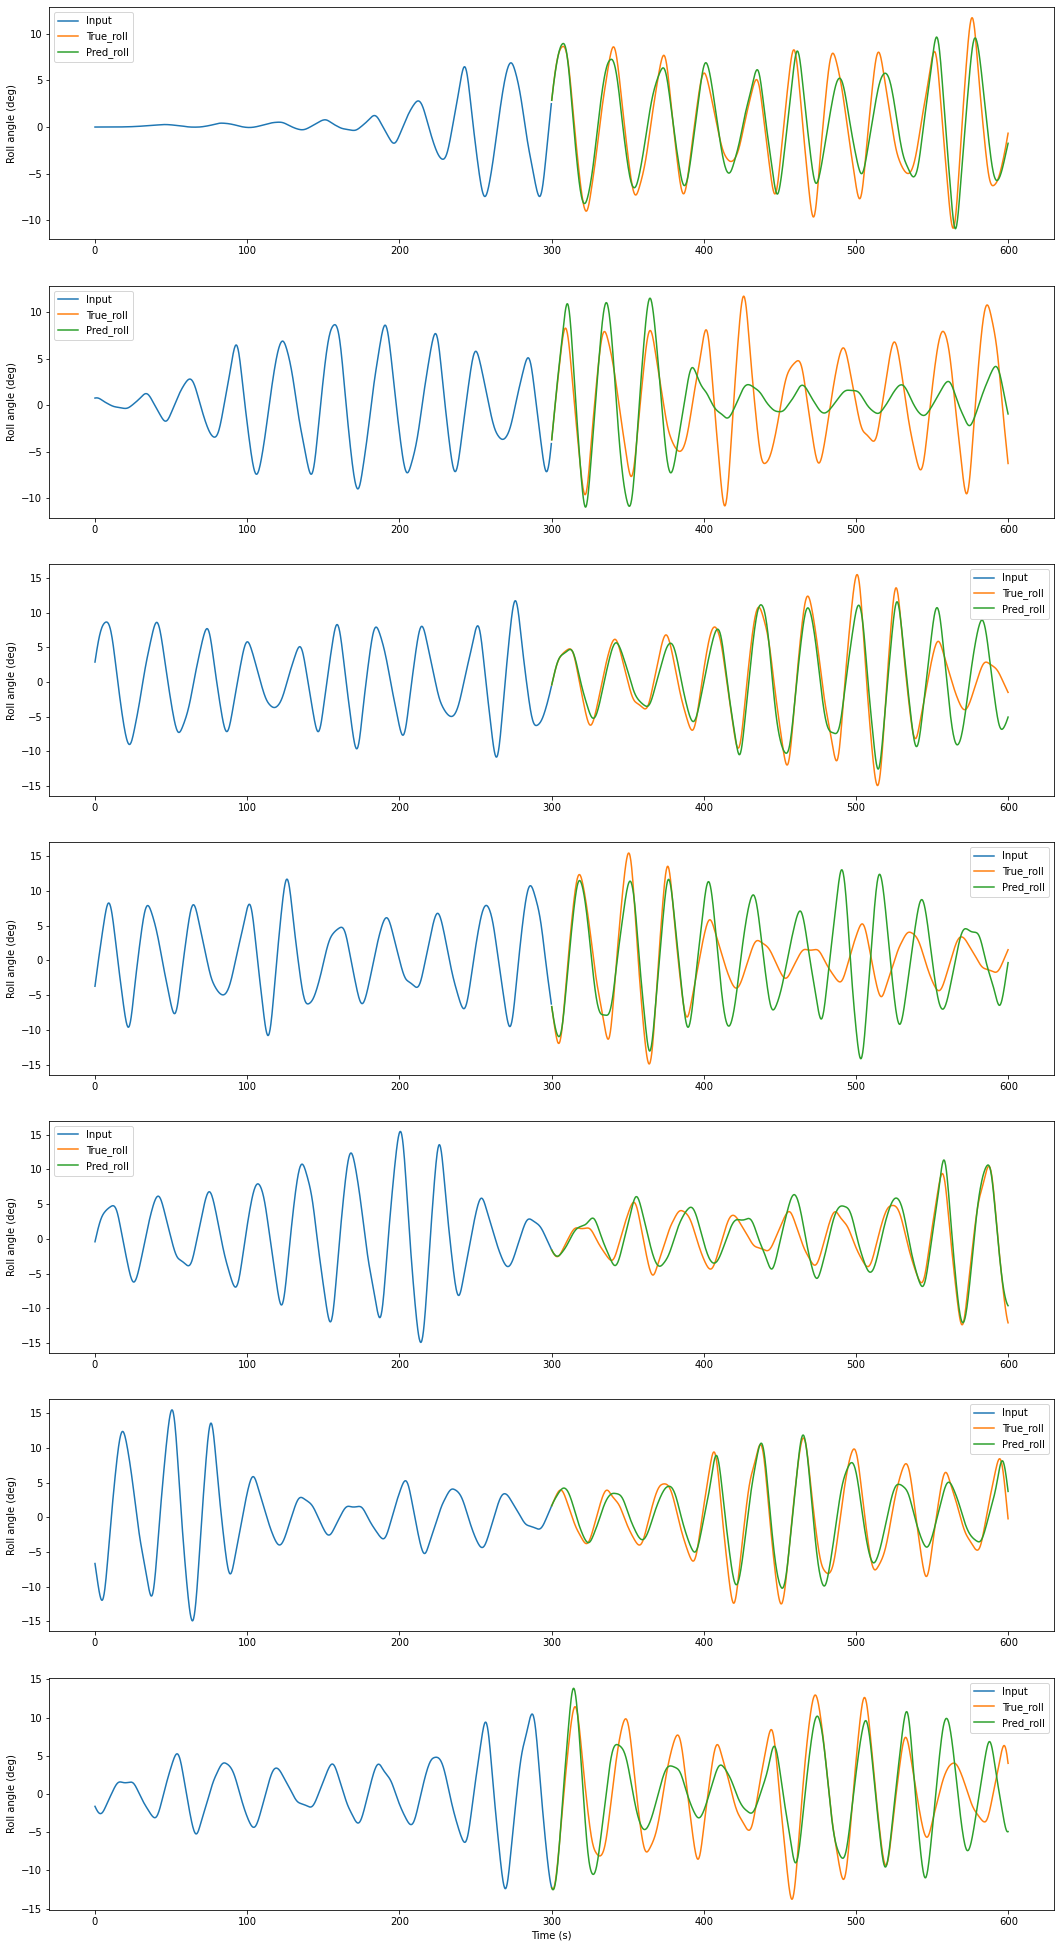

In [39]:
plot_inference(test_in[:,:,0], test_true, test_pred, nos=[0,1,2,3,4,5,6], cut=1)